# Tweet sentiment analysis

In [2]:
import tweepy
from textblob import TextBlob
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

### Connecting to twitter API

In [3]:
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

### Helper functions

In [8]:
def format_tweet(tweet):
    processed_tweet=""
    if "RT @" or "RT" not in tweet.full_text:
        for word in tweet.full_text.split():
            
            # Removing URL from tweet
            processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
            
            # Remove all the special characters
            processed_word = re.sub(r'\W', '', processed_word)

            # remove all single characters
            processed_word = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_word)

            # Remove single characters from the start
            processed_word = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_word) 

            # Substituting multiple spaces with single space
            processed_word = re.sub(r'\s+', '', processed_word, flags=re.I)

            # Removing prefixed 'b'
            processed_word = re.sub(r'^b\s+', ' ', processed_word)

            # Converting to Lowercase
            processed_word = processed_word.lower()
            processed_tweet= processed_tweet+" "+processed_word

        return processed_tweet +"~ "+ str(tweet.created_at)
            
    else:
        return


### Getting tweets from Twitter API

In [35]:
# Authenticates and connects to API
auth = tweepy.OAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
auth.set_access_token(creds['ACCESS_TOKEN'], creds['ACCESS_SECRET'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Gets tweets based on query
query = "#heatwave -filter=retweets"
cursor = tweepy.Cursor(api.search, q= query, lang="en", since='2016-01-01', tweet_mode='extended').items(200)

# Filters out None objects
temp = [format_tweet(tweet) for tweet in cursor]
tweets = filter(None, temp)
tweet_texts = [tweet.split('~')[0] for tweet in tweets]

## Sentiment analysis with TextBlob

In [11]:
sentiment_tweets = [TextBlob(tweet) for tweet in tweets]
sentiment_values = [[round(tweet.sentiment.polarity,2), tweet.split("~")[0], tweet.split("~")[1]] for tweet in sentiment_tweets]

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet", "date"])
sentiment_df.head()

,polarity,tweet,date
0,1.00,overload yourself with this delightful flavou...,2019-09-19 13:47:02
1,0.35,couple of corona and more of this tonite than...,2019-09-19 13:35:09
2,0.00,heatwave blowout sale the summer heat isnt go...,2019-09-19 13:30:35
3,0.29,45c113f in basrah iq hottest city in the wor...,2019-09-19 13:00:49
4,0.06,ocean heatwave intensifies in pacific with ri...,2019-09-19 13:00:10


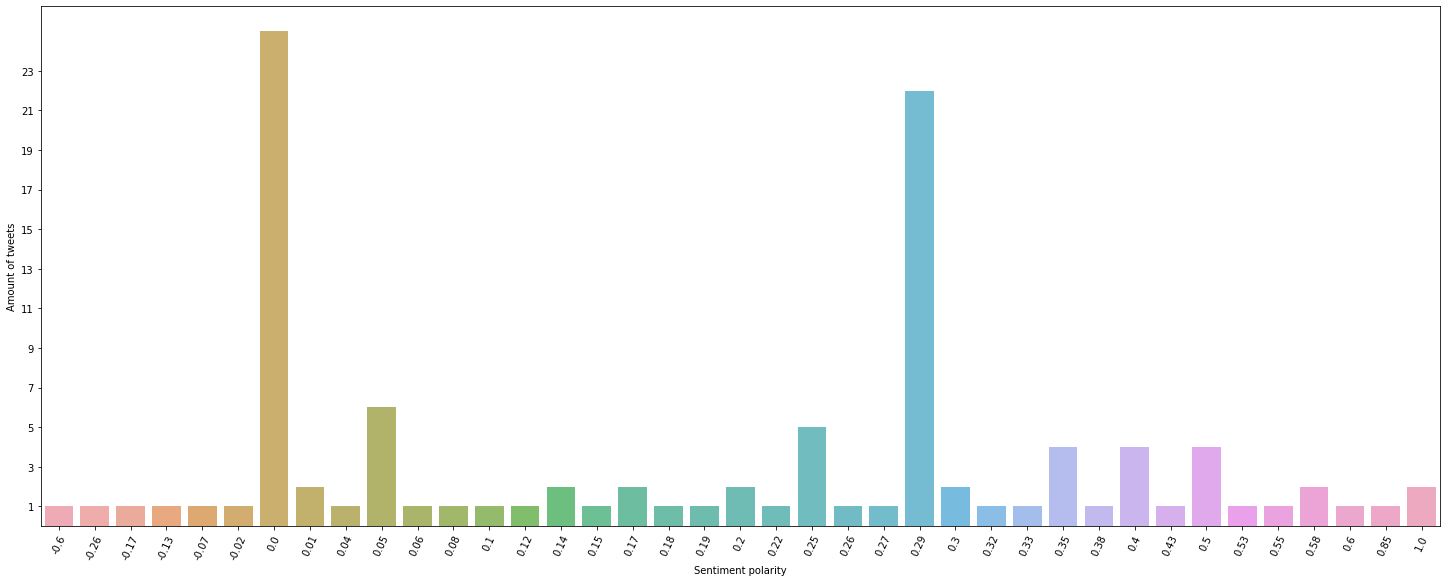

In [12]:
sentiment_count = sentiment_df["polarity"].value_counts()
x = sentiment_count.index
y = sentiment_count.values
plt.figure(figsize=(20, 8))
sns.barplot(x, y, alpha=0.8)
plt.yticks(np.arange(min(y), max(y), step=2))
plt.xticks(plt.xticks()[0], rotation=65)
plt.tight_layout()
plt.ylabel("Amount of tweets")
plt.xlabel("Sentiment polarity")

plt.show()

As you can see, this sentiment analysis is very basic and not very accurate
This analysis would point out that most people who tweet about heatwaves, have a possitive or neutral sentiment about it. 
* sentiment polarity < 0 &nbsp;&nbsp;&nbsp; => negative 
* sentiment polarity > 0 &nbsp;&nbsp;&nbsp; => positive 
* sentiment polarity = 0 &nbsp;&nbsp;&nbsp; => neutral

## Sentiment analysis with SciKit Learn (Random Forest)

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization (reduces words to dictionary root form)

In [37]:
documents = []
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

for tweet in tweet_texts:
    document = tweet.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    documents.append(document)

In [42]:
# tfidf = term frequency, inverse document frequency ()
vectorizer = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.80, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(documents).toarray()
X, y = processed_features.iteritems()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


AttributeError: 'numpy.ndarray' object has no attribute 'iteritems'